# Projet Simulation et Monte Carlo
## Wall Street
#### Youssef Dhaoui, Loïc Diridoullou, Louise Ferbach 

## Introduction 

Une option asiatique est une option dont le payoff dépend non pas seulement de la
valeur terminale de son sous-jacent (cas des options européennes) mais aussi de la valeur du
sous-jacent au cours de la vie de l’option.
La période de calcul de la moyenne et la manière dont elle est calculée sont spécifiées dans le contrat.
On s’intéresse ici à un call asiatique dont le payoff est :

$$ C_{T}= e^{-rT} \mathbb{E}[max (0, \frac{1}{k}\sum_{i=1}^k S(t_{i}) - K)] $$


Le principal avantage des options asiatiques est de diminuer le risque de volatilité inhérent aux actifs financiers. 
Mais en contrepartie, le valeur d’une option asiatique est plus compliquée à calculer qu’une option Européenne.
Au cours de ce projet on va tenter de pricer un call asiatique à l'aide de méthodes Monte-Carlo.

On importe les packages nécessaires

In [1]:
import numpy as np
import random as rd
import matplotlib.pyplot as plt
from scipy.stats import norm
import math
import pandas as pd

On commence par stocker les variables globales

In [2]:
# on commence par stocker les variables globales
S_0 = 100
T = 1
r = 0.05
sigma = 0.3
K = 100
mu = 0.05 
k = 20
n = 10000

In [3]:
dates = [i/k for i in range(1,k+1)]

## Génération du mouvement brownien

Afin de de pricer ce call asiatique, on aura besoin de générer les points de la trajectoire du sous-jacent ($S_{t_{1}},S_{t_{1}},...,S_{t_{1}}$).

Ainsi, il suffit de simuler k points de la trajectoire du mouvement brownien ($B_{t_{1}},B_{t_{1}},...,B_{t_{1}}$)

Un mouvement brownien a pour propriété que ses accroissements sont indépendants et suivent une loi normale centrée de variance ($t_{i+1}-t_{i}$), $ B_{t_{i+1}}-B_{t_{i}} \sim \sqrt{(t_{i+1}-t_{i})} \mathcal{N}(0,\,1) $

Ainsi pour tout i dans l'intervalle $[1,k-1]$,on génère le mouvement brownien selon la formule 
$B_{t_{i+1}} = B_{t_{i}} + \sqrt{(t_{i+1}-t_{i})} X_{i}$

Tel que les $X_{i}$ sont des variables aléatoires normales centrées réduites et indépendantes. 


In [4]:
def brownian_path():
    acc = [0] +[rd.gauss(0, np.sqrt(1/k)) for i in range(k-1)]
    sim = np.cumsum(acc)
    return sim

In [5]:
brownian_path()

array([0.        , 0.29672669, 0.19700734, 0.33821837, 0.8419841 ,
       1.27716886, 1.54262555, 1.79085531, 1.72001037, 1.84570129,
       2.12681886, 2.03953551, 1.88642793, 1.83631483, 1.74150415,
       1.87684033, 2.19378386, 1.98507333, 2.2382388 , 2.61020345])

Tracer du trajet brownien 

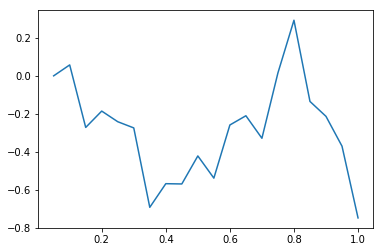

In [6]:
plt.plot(dates, brownian_path())

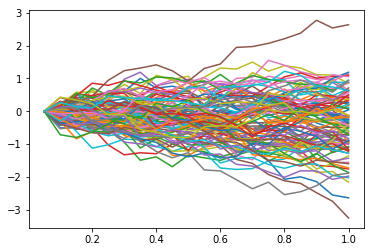

In [7]:
tab = []

for i in range(100):
    plt.plot(dates,brownian_path())

## Partie 1

#### Estimation naïve:

On réalise n simulations de trajectoires du sous-jacent, on génère donc $k\times n$ normales indépendantes.

L’espérance du payoff est simplement estimée par la moyenne : 
    $$ C_{T}= e^{-rT}\frac{1}{n} \sum_{s=1}^n max (0, \frac{1}{k}\sum_{i=1}^k S_{s}(t_{i}) - K)  $$


D’après la loi des grands nombres, cet estimateur converge presque sûrement vers l’espérance. De plus, grâce au théorème centrale limite, on peut obtenir des intervalles de confiance.

$\sqrt{n}(\frac{1}{n} \sum_{s=1}^n C_{T,s} - E[C_{T}])$ converge en loi vers une normale $\mathcal{N}(0,\, \omega)$

Avec $C_{T,s} = e^{-rT} max (0, \frac{1}{k}\sum_{i=1}^k S_{s}(t_{i}) - K) $

L'écart-type est donc donné par $\frac{\omega}{\sqrt{n}}$ et les intervalles de confiance à 95% et à 99% s'écrivent sous la forme:
$$IC_{95\%} = [m-1.96*\frac{\omega}{\sqrt{n}},m+1.96*\frac{\omega}{\sqrt{n}}]$$
$$IC_{99\%} = [m-2.58*\frac{\omega}{\sqrt{n}},m+2.58*\frac{\omega}{\sqrt{n}}]$$

In [9]:
def estimation(n,K=K,sigma=sigma):
    payoff = [None]*n
    for i in range(n):
        MB = brownian_path()
        temp=0
        for j in range(1,k+1):
            temp += S_0*np.exp((mu-(sigma**2)/2)*(j/k) + sigma*MB[j-1])
        temp=temp/k
        val=max(0, temp-K)
        payoff[i] = np.exp(-r*T)*val
    payoff = np.array(payoff)
    estimation = np.mean(payoff)
    sd = np.std(payoff)
    inter_95 = [estimation - 1.96*sd/np.sqrt(len(payoff)), estimation + 1.96*sd/np.sqrt(len(payoff))]
    inter_99 = [estimation - 2.58*sd/np.sqrt(len(payoff)), estimation + 2.58*sd/np.sqrt(len(payoff))]
    return estimation, sd, inter_95, inter_99

In [8]:
estimation(n)

(7.566138068326702,
 11.683452179408773,
 [7.33714240561029, 7.795133731043114],
 [7.264705002097956, 7.867571134555448])

En appliquant notre estimation Monte-Carlo simple pour 10 000 trajectoires, et en prenant les paramètres de l’énoncé, on obtient un prix de 7.73 euros. Les intervalles de confiance à 95% et à 99% sont respectivement $[7.50, 7.96]$ et $[7.43,8.03]$
L'écart-type est de 11.63.

On va maintenant chercher à représenter l'évolution de l'estimation du prix (avec intervalles de confiance) en fonction du nombre de simulations $n$.

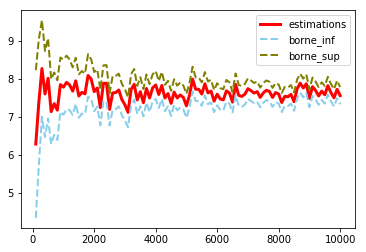

In [13]:
def plot(modele,inter=95):
    iterations=[100*i for i in range(1,101)]
    estimations=[]
    intervalle=[]
    if inter==95:
        for i in range(1,101):
            mod=modele(100*i)
            estimations.append(mod[0])
            intervalle.append(mod[2])
    if inter==99:
        for i in range(1,101):
            mod=modele(100*i)
            estimations.append(mod[0])
            intervalle.append(mod[3])
    intervalle_inf=[inte[0] for inte in intervalle]
    intervalle_sup=[inte[1] for inte in intervalle]
    df=pd.DataFrame({'iterations':iterations,'estimations' : estimations, 'borne_inf':intervalle_inf,'borne_sup':intervalle_sup})
    plt.plot( 'iterations', 'estimations', data=df, color='red', linewidth=3)
    plt.plot( 'iterations', 'borne_inf', data=df, color='skyblue', linewidth=2, linestyle='dashed')
    plt.plot( 'iterations', 'borne_sup', data=df, color='olive', linewidth=2, linestyle='dashed')
    plt.legend()

    #plt.plot(iterations,estimations,col='red',xlab='nombre d itérations', ylab='estimation du prix obtenue')
plot(estimation, 95)

On a tracé ci-dessus l'évolution du prix extimé avec intervalle de confiance à $95\%$, de 100 à 10000 itérations.

##### Estimation avec variable antithétique

Vu que le mouvement brownien est symétrique, on peut tenter l'approche de la variable antithétique. Dans le cadre de cette approche, on estime l'espérance du prix du call asiatique par:

   $$ C_{T}= \frac{1}{n} \sum_{s=1}^n \frac{C_{T,s}(B_{s}) + C_{T,s}(-B_{s})}{2} $$ 





In [10]:
def estimation_VA(n, K=K,sigma=sigma):
    payoff = [None]*n
    for i in range(n):
        MB = brownian_path()
        temp1, temp2 = 0, 0
        for j in range(1,k+1):
            temp1 += S_0*np.exp((mu-(sigma**2)/2)*(j/k) + sigma*MB[j-1])
            temp2 += S_0*np.exp((mu-(sigma**2)/2)*(j/k) + sigma*(-MB[j-1]))
        temp1, temp2 = temp1/k, temp2/k
        val1, val2 = max(0, temp1-K), max(0, temp2-K)
        payoff[i] = np.exp(-r*T)*(val1+val2)
    payoff = np.array(payoff)
    estimation = np.sum(payoff)/(2*n)
    sd = np.sqrt(np.mean(payoff-np.sum(payoff)/(2*n)))
    inter_95 = [estimation - 1.96*sd/np.sqrt(len(payoff)), estimation + 1.96*sd/np.sqrt(len(payoff))]
    inter_99 = [estimation - 2.58*sd/np.sqrt(len(payoff)), estimation + 2.58*sd/np.sqrt(len(payoff))]
    return estimation, sd, inter_95, inter_99

In [11]:
estimation_VA(n)

(7.510407070610125,
 2.7405121912901835,
 [7.456693031660837, 7.564121109559412],
 [7.439701856074838, 7.581112285145411])

En appliquant notre estimation Monte-Carlo avec variable antithétique pour 10 000 trajectoires, et en prenant les paramètres de l’énoncé, on obtient un prix de 7.62 euros. Les intervalles de confiance à 95% et à 99% sont respectivement $[7.57, 7.68]$ et $[7.55,7.69]$
L'écart-type est de 2.76.

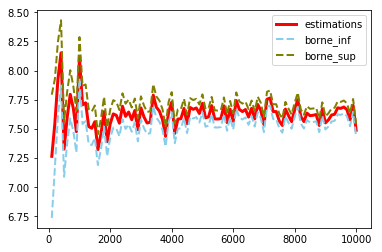

In [12]:
plot(estimation_VA,95)

### Variable de contrôle

Le principe est de trouver une variable Z centrée, intégrable à l'ordre 2 et un réel $\beta$ qui minimise la variance de l'estimateur :
$I_{\beta,n} = \frac{1}{n} \sum_{s=1}^n C_{T,s} - \beta Z_{s} $

qui est un estimateur qui converge presque sûrement vers le prix du call.

Le $\beta$ minimisant la variance de cet estimateur est donné par l'expression :

$$ \beta =\frac{ cov(C_{T},Z) }{var(Z)}$$

##### Estimation avec variable de contrôle 1

Comme première variable de controle, on décide de choisir le prix du sous-jacent duquel on soustrait sa moyenne (le prix initial du sous-jacent). Cette variable vérifie la condition d'une corrélation non nulle avec le prix du call asiatique.

In [13]:
def estimation_CV1(n, K=K,sigma=sigma):
    payoff = [None]*n
    CV = [None]*n
    for i in range(n):
        MB = brownian_path()
        temp=0
        for j in range(1,k+1):
            temp += S_0*np.exp((mu-(sigma**2)/2)*(j/k) + sigma*MB[j-1])
        temp=temp/k
        val=max(0, temp-K)
        payoff[i] = np.exp(-r*T)*val
        CV[i] = S_0*np.exp(-r*T)*np.exp((mu-sigma**2/2)*T + sigma*MB[k-1])-S_0
    beta = (np.cov(payoff, CV)[0,1])/np.var(CV)
    CV=beta*np.array(CV)
    payoff = np.array(payoff-CV)
    estimation = np.mean(payoff)
    sd = np.std(payoff)
    inter_95 = [estimation - 1.96*sd/np.sqrt(len(payoff)), estimation + 1.96*sd/np.sqrt(len(payoff))]
    inter_99 = [estimation - 2.58*sd/np.sqrt(len(payoff)), estimation + 2.58*sd/np.sqrt(len(payoff))]
    return estimation, sd, inter_95, inter_99

In [14]:
estimation_CV1(n)

(7.637524297053665,
 6.559921942551096,
 [7.508949826979664, 7.766098767127667],
 [7.468278310935847, 7.806770283171484])

En appliquant notre estimation Monte-Carlo avec variable de contrôle pour 10 000 trajectoires, et en prenant les paramètres de l’énoncé, on obtient de même un prix de 7.62 euros. Les intervalles de confiance à 95% et à 99% sont respectivement $[7.49, 7.75]$ et $[7.45,7.79]$.
L'écart-type est de 6.67.

Cette méthode marche mieux que le Monte-Carlo classique, mais a une performance moins élevée que la méthode de variable antithétique.

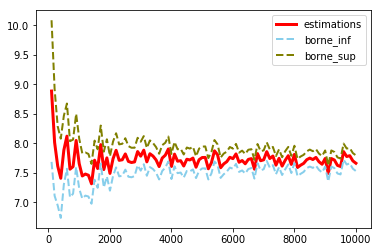

In [15]:
plot(estimation_CV1,95)

##### Estimation avec variable de contrôle 2
Comme deuxième tentative, on choisit le prix du call européen duquel on soustrait aussi sa moyenne. Cette variable vérifie la condition d'une corrélation non nulle avec le prix du call asiatique.


In [16]:
def estimation_CV2(n, K=K,sigma=sigma):
    d1 = 1/(sigma*np.sqrt(T))*(np.log(S_0/K)+(r+(1/2)*sigma**2)*T)
    d2 = d1 - sigma*np.sqrt(T)
    CV2_mean = S_0*norm.cdf(d1)-K*np.exp(-r*T)*norm.cdf(d2)
    
    payoff = [None]*n
    CV = [None]*n
    for i in range(n):
        MB = brownian_path()
        temp=0
        for j in range(1,k+1):
            temp += S_0*np.exp((mu-(sigma**2)/2)*(j/k) + sigma*MB[j-1])
        temp=temp/k
        val=max(0, temp-K)
        payoff[i] = np.exp(-r*T)*val
        CV[i] = np.exp(-r*T)*max(S_0*np.exp((mu-sigma**2/2)*T + sigma*MB[k-1])-K,0)-CV2_mean
    beta = (np.cov(payoff, CV)[0,1])/np.var(CV)
    CV=beta*np.array(CV)
    payoff = np.array(payoff-CV)
    estimation = np.mean(payoff)
    sd = np.std(payoff)
    inter_95 = [estimation - 1.96*sd/np.sqrt(len(payoff)), estimation + 1.96*sd/np.sqrt(len(payoff))]
    inter_99 = [estimation - 2.58*sd/np.sqrt(len(payoff)), estimation + 2.58*sd/np.sqrt(len(payoff))]
    return estimation, sd, inter_95, inter_99

In [17]:
estimation_CV2(n)

(7.878840895424958,
 6.114529446411445,
 [7.758996118275293, 7.998685672574622],
 [7.721086035707542, 8.036595755142374])

En appliquant notre estimation Monte-Carlo avec le call européen comme variable de contrôle, pour 10 000 trajectoires, et en prenant les paramètres de l’énoncé, on obtient un prix de 7.84 euros. Les intervalles de confiance à 95% et à 99% sont respectivement $[7.72, 7.96]$ et $[7.68,8.00]$.
L'écart-type est de 6.17.

L'écart-type obtenu avec cette variable est légèrement inférieur à celui obtenu avec le sous-jacent. 

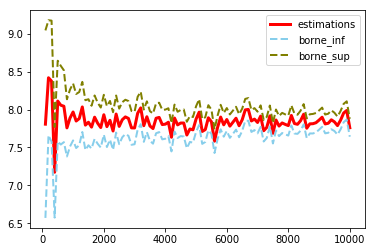

In [21]:
plot(estimation_CV2,95)

In [11]:
def estimation_CV3(n, K=K,sigma=sigma):
    CV31 = [None]*n*10
    for i in range(10*n):
        MB = brownian_path()
        temp=0
        for j in range(k):
            temp += np.log(S_0)+((mu-sigma**2/2)*((j+1)/k) + sigma* MB[j])
        temp = np.exp(temp/k)
        CV31[i]=np.exp(-r*T)*max(temp-K, 0)
    CV31_mean=np.mean(CV31)
    
        
    
    
    payoff = [None]*n
    CV3=[None]*n
    
    for i in range(n):
        MB = brownian_path()
        temp,temp1=0,0
        for j in range(1,k+1):
            temp += S_0*np.exp((mu-(sigma**2)/2)*(j/k) + sigma*MB[j-1])
            temp1 = temp1+np.log(S_0)+((mu-sigma**2/2)*((j+1)/k) + sigma* MB[j-1])
        temp=temp/k
        temp1 = np.exp(temp1/k)
        val=max(0, temp-K)
        val1=max(0, temp1-K)
        CV3[i]=np.exp(-r*T)*val1-CV31_mean
        payoff[i] = np.exp(-r*T)*val
        
    beta = (np.cov(payoff, CV3)[0,1])/np.var(CV3)
    CV3=beta*np.array(CV3)
    payoff = np.array(payoff-CV3)
    estimation = np.mean(payoff)
    sd = np.std(payoff)
    inter_95 = [estimation - 1.96*sd/np.sqrt(len(payoff)), estimation + 1.96*sd/np.sqrt(len(payoff))]
    inter_99 = [estimation - 2.58*sd/np.sqrt(len(payoff)), estimation + 2.58*sd/np.sqrt(len(payoff))]
    return estimation, sd, inter_95, inter_99

In [23]:
estimation_CV3(10000)

(7.594283024350979,
 0.48422981304858315,
 [7.584792120015226, 7.603773928686731],
 [7.5817898951743254, 7.606776153527632])

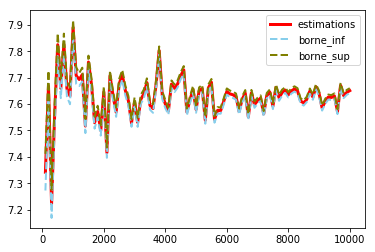

In [15]:
plot(estimation_CV3,95)

##### Estimation avec Quasi Monte Carlo

Lors de la simulation du mouvement brownien, l’aléa provenant de la simulation de variables de loi normale (0,1) produit des erreurs d'éstimation. 
Le Quasi Monte-Carlo consiste à remplacer les suites aléatoires par des suites déterministes (quasi-random) afin de réduire ces erreurs.
On utilise ici les suites de Halton pour simuler le mouvement Brownien

$\forall i \in  (1,...10 000)$, i se décompose dans la base b:
$   i = \sum_{j=0}^k a_{j}(i)b^{j}     $ 

La i-ème simulation de la loi uniforme sur $[0,1]$ dans la base b s'écrit:  $U_{i} = \sum_{j=0}^k a_{j}(i)b^{-1-j}$

In [11]:
def primes_from_2_to(n):
    sieve = np.ones(n // 3 + (n % 6 == 2), dtype=np.bool)
    for i in range(1, int(n ** 0.5) // 3 + 1):
        if sieve[i]:
            k = 3 * i + 1 | 1
            sieve[k * k // 3::2 * k] = False
            sieve[k * (k - 2 * (i & 1) + 4) // 3::2 * k] = False
    return np.r_[2, 3, ((3 * np.nonzero(sieve)[0][1:] + 1) | 1)]


def van_der_corput(n_sample, base=2):
    sequence = []
    for i in range(n_sample):
        n_th_number, denom = 0., 1.
        while i > 0:
            i, remainder = divmod(i, base)
            denom *= base
            n_th_number += remainder / denom
        sequence.append(n_th_number)

    return sequence


def halton(dim, n_sample):
    big_number = 10
    while 'Not enough primes':
        base = primes_from_2_to(big_number)[:dim]
        if len(base) == dim:
            break
        big_number += 1000

    # Generate a sample using a Van der Corput sequence per dimension.
    sample = [van_der_corput(n_sample + 1, dim) for dim in base]
    sample = np.stack(sample, axis=-1)[1:]

    return sample

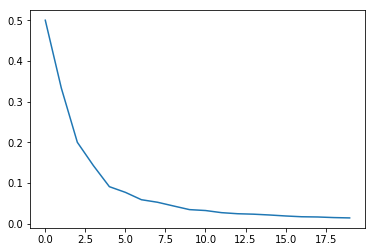

In [12]:
simu=halton(k,n)
simu[0,:]
plt.plot(simu[0,:])

In [13]:
def discrep(n, simu):
    b=0
    k=0
    D = [None]*11
    while (b<1):
        sum = 0
        for i in range(n):
            for j in range(k):
                if (simu[i][j] < b):
                    sum += 1
        D[k] = abs((sum/len(simu))-b)
        b += 0.1
        k += 1
    return(max(D))

In [14]:
simu = halton(k, n)
#simu
#discrep(n,simu)

In [15]:
def estimation_qmc(n, K=K,sigma=sigma):
    payoff = [None]*n
    D = discrep(n, simu)
    
    for i in range(n):
        MB = np.cumsum(norm.ppf(simu[i,:], scale=np.sqrt(1/k)))
        temp=0
        for j in range(1,k+1):
            temp += S_0*np.exp((mu-(sigma**2)/2)*(j/k) + sigma*MB[j-1])
        temp=temp/k
        val=max(0, temp-K)
        payoff[i] = np.exp(-r*T)*val
    payoff = np.array(payoff)
    estimation = np.mean(payoff)
    sd = np.std(payoff)
    inter_95 = [estimation - 1.96*sd/np.sqrt(len(payoff)), estimation + 1.96*sd/np.sqrt(len(payoff))]
    inter_99 = [estimation - 2.58*sd/np.sqrt(len(payoff)), estimation + 2.58*sd/np.sqrt(len(payoff))]
    KH = [estimation - np.var(payoff)*D, estimation + np.var(payoff*D)]
    
    return estimation, sd, inter_95, inter_99, #KH

In [16]:
estimation_qmc(n)

(8.098457840891877,
 12.095192638950826,
 [7.861392065168441, 8.335523616615314],
 [7.786401870806945, 8.410513810976807])

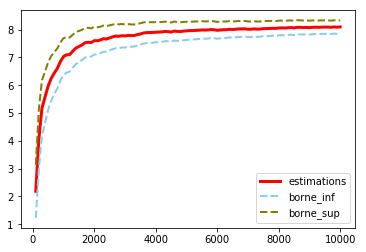

In [30]:
plot(estimation_qmc,95)

QMC permet une convergence plus rapide de
l’estimateur

###  RQMC 

In [17]:
def estimation_rqmc():
 
    #On cherche Ã  obtenir un Ã©chantillon de loi normale Ã  partir de cet Ã©chantillon, on s'aide de la mÃ©thode de la fonction de rÃ©partition inverse.
    #On peut utiliser aussi plus simplement apply(halton(n = 20, dim = 20, normal = TRUE),2,cumsum) qui existe sous randtoolbox mais c'est opaque comment est obtenu la loi normale donc je prÃ©fÃ¨re le faire Ã  la main
    payoff = [None]*n
    
    for i in range(n):
        U = np.random.uniform(size=n)
        MB = np.cumsum(norm.ppf((simu[i,:]+U[i])%1, scale=np.sqrt(1/k)))
        
        temp=0
        for j in range(k):
            temp += S_0*np.exp((mu-(sigma**2)/2)*(j/k) + sigma*MB[j-1])
        temp=temp/k
        val=max(0, temp-K)
        payoff[i] = np.exp(-r*T)*val
  
    payoff = np.array(payoff)
    estimation = np.mean(payoff)
    sd = np.std(payoff)
    inter_95 = [estimation - 1.96*sd/np.sqrt(len(payoff)), estimation + 1.96*sd/np.sqrt(len(payoff))]
    inter_99 = [estimation - 2.58*sd/np.sqrt(len(payoff)), estimation + 2.58*sd/np.sqrt(len(payoff))]
    
    return estimation, sd, inter_95, inter_99

In [18]:
estimation_rqmc()

(8.304931999667168,
 12.54857598977392,
 [8.058979910267599, 8.550884089066738],
 [7.981178739131002, 8.628685260203335])

### Combinaison des différentes méthodes de réduction de variance

##### Estimation QMC avec variable antithétique

In [33]:
def estimation_qmc_va(n, K=K,sigma=sigma):
    payoff = [None]*n
    D = discrep(n, simu)
    
    for i in range(n):
        MB = np.cumsum(norm.ppf(simu[i,:], scale=np.sqrt(1/k)))
        temp1, temp2 = 0, 0
        for j in range(1,k+1):
            temp1 += S_0*np.exp((mu-(sigma**2)/2)*(j/k) + sigma*MB[j-1])
            temp2 += S_0*np.exp((mu-(sigma**2)/2)*(j/k) + sigma*(-MB[j-1]))
        temp1, temp2 = temp1/k, temp2/k
        val1, val2 = max(0, temp1-K), max(0, temp2-K)
        payoff[i] = np.exp(-r*T)*(val1+val2)
    payoff = np.array(payoff)
    estimation = np.sum(payoff)/(2*n)
    sd = np.sqrt(np.mean(payoff-np.sum(payoff)/(2*n)))
    inter_95 = [estimation - 1.96*sd/np.sqrt(len(payoff)), estimation + 1.96*sd/np.sqrt(len(payoff))]
    inter_99 = [estimation - 2.58*sd/np.sqrt(len(payoff)), estimation + 2.58*sd/np.sqrt(len(payoff))]
    KH = [estimation - np.var(payoff)*D, estimation + np.var(payoff*D)]
    
    return estimation, sd, inter_95, inter_99, #KH

In [34]:
estimation_qmc_va(n)

(8.240415939799789,
 2.8706124677148237,
 [8.184151935432578, 8.296679944167],
 [8.166354138132746, 8.314477741466831])

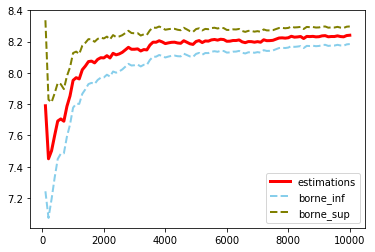

In [64]:
plot(estimation_qmc_va,95)

##### Estimation QMC avec variable de contrôle

In [35]:
def estimation_qmc_CV1(n, K=K,sigma=sigma):
    payoff = [None]*n
    CV = [None]*n
    D = discrep(n, simu)
    for i in range(n):
        MB = np.cumsum(norm.ppf(simu[i,:], scale=np.sqrt(1/k)))
        temp=0
        for j in range(1,k+1):
            temp += S_0*np.exp((mu-(sigma**2)/2)*(j/k) + sigma*MB[j-1])
        temp=temp/k
        val=max(0, temp-K)
        payoff[i] = np.exp(-r*T)*val
        CV[i] = S_0*np.exp(-r*T)*np.exp((mu-sigma**2/2)*T + sigma*MB[k-1])-S_0
    beta = (np.cov(payoff, CV)[0,1])/np.var(CV)
    CV=beta*np.array(CV)
    payoff = np.array(payoff-CV)
    estimation = np.mean(payoff)
    sd = np.std(payoff)
    inter_95 = [estimation - 1.96*sd/np.sqrt(len(payoff)), estimation + 1.96*sd/np.sqrt(len(payoff))]
    inter_99 = [estimation - 2.58*sd/np.sqrt(len(payoff)), estimation + 2.58*sd/np.sqrt(len(payoff))]
    KH = [estimation - np.var(payoff)*D, estimation + np.var(payoff*D)]

    return estimation, sd, inter_95, inter_99, #KH

In [36]:
estimation_qmc_CV1(n)

(8.303213205555945,
 7.1430252095104,
 [8.163209911449542, 8.443216499662348],
 [8.118923155150577, 8.487503255961313])

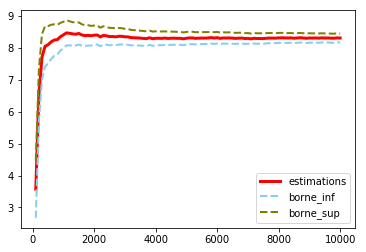

In [65]:
plot(estimation_qmc_CV1,95)

In [37]:
def estimation_qmc_CV2(n, K=K,sigma=sigma):
    d1 = 1/(sigma*np.sqrt(T))*(np.log(S_0/K)+(r+(1/2)*sigma**2)*T)
    d2 = d1 - sigma*np.sqrt(T)
    CV2_mean = S_0*norm.cdf(d1)-K*np.exp(-r*T)*norm.cdf(d2)
    D = discrep(n, simu)
    
    payoff = [None]*n
    CV = [None]*n
    for i in range(n):
        MB = np.cumsum(norm.ppf(simu[i,:], scale=np.sqrt(1/k)))
        temp=0
        for j in range(1,k+1):
            temp += S_0*np.exp((mu-(sigma**2)/2)*(j/k) + sigma*MB[j-1])
        temp=temp/k
        val=max(0, temp-K)
        payoff[i] = np.exp(-r*T)*val
        CV[i] = np.exp(-r*T)*max(S_0*np.exp((mu-sigma**2/2)*T + sigma*MB[k-1])-K,0)-CV2_mean
    beta = (np.cov(payoff, CV)[0,1])/np.var(CV)
    CV=beta*np.array(CV)
    payoff = np.array(payoff-CV)
    estimation = np.mean(payoff)
    sd = np.std(payoff)
    inter_95 = [estimation - 1.96*sd/np.sqrt(len(payoff)), estimation + 1.96*sd/np.sqrt(len(payoff))]
    inter_99 = [estimation - 2.58*sd/np.sqrt(len(payoff)), estimation + 2.58*sd/np.sqrt(len(payoff))]
    KH = [estimation - np.var(payoff)*D, estimation + np.var(payoff*D)]

    return estimation, sd, inter_95, inter_99, KH

In [38]:
estimation_qmc_CV2(n)

(8.356496982252926,
 6.514658164661183,
 [8.228809682225567, 8.484184282280285],
 [8.188418801604668, 8.524575162901185],
 [-373.6104420392266, 3446.0589481755683])

In [ ]:
plot(estimation_qmc_CV2,95)

In [39]:
def estimation_qmc_CV3(n, K=K,sigma=sigma):
    
    simu1=halton(k,10*n)
    
    CV31 = [None]*n*10
    for i in range(10*n):
        MB = np.cumsum(norm.ppf(simu1[i,:], scale=np.sqrt(1/k)))
        temp=0
        for j in range(k):
            temp += np.log(S_0)+((mu-sigma**2/2)*((j+1)/k) + sigma* MB[j])
        temp = np.exp(temp/k)
        CV31[i]=np.exp(-r*T)*max(temp-K, 0)
    CV31_mean=np.mean(CV31)
 
    
    payoff = [None]*n
    CV3 = [None]*n
    #D = discrep(n, simu)
    
    for i in range(n):
        MB = np.cumsum(norm.ppf(simu[i,:], scale=np.sqrt(1/k)))
        temp,temp1=0,0
        for j in range(1,k+1):
            temp += S_0*np.exp((mu-(sigma**2)/2)*(j/k) + sigma*MB[j-1])
            temp1 = temp1+np.log(S_0)+((mu-sigma**2/2)*((j+1)/k) + sigma* MB[j-1])
        temp=temp/k
        temp1 = np.exp(temp1/k)
        val=max(0, temp-K)
        val1=max(0, temp1-K)
        CV3[i]=np.exp(-r*T)*val1-CV31_mean
        payoff[i] = np.exp(-r*T)*val
        
    beta = (np.cov(payoff, CV3)[0,1])/np.var(CV3)
    CV3=beta*np.array(CV3)
    payoff = np.array(payoff-CV3)
    estimation = np.mean(payoff)
    sd = np.std(payoff)
    inter_95 = [estimation - 1.96*sd/np.sqrt(len(payoff)), estimation + 1.96*sd/np.sqrt(len(payoff))]
    inter_99 = [estimation - 2.58*sd/np.sqrt(len(payoff)), estimation + 2.58*sd/np.sqrt(len(payoff))]
    return estimation, sd, inter_95, inter_99
    #KH = [estimation - np.var(payoff)*D, estimation + np.var(payoff*D)]

    return estimation, sd, inter_95, inter_99, #KH

In [40]:
estimation_qmc_CV3(10000)

(8.220471430025121,
 0.4666652105887573,
 [8.211324791897582, 8.22961806815266],
 [8.20843146759193, 8.232511392458312])

In [ ]:
plot(estimation_qmc_VC3,95)

Pour mieux comparer les modèles, on va représenter leurs estimations et intervalles de confiance correspondants sur un même graphique.

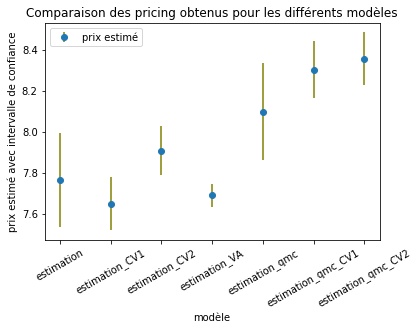

In [67]:
modeles=[estimation,estimation_VA,estimation_CV1,estimation_CV2,estimation_CV3,estimation_qmc,estimation_qmc_CV1,estimation_qmc_CV2,estimation_qmc_CV3,estimation_rqmc]
inter=95
estimations=[]
intervalle=[]
inf=[]
sup=[]
err=[]
for mode in modeles:
    mod=mode(n)
    estimations.append(mod[0])
    err.append(1.96*mod[1]/np.sqrt(n))
    if inter==95 :
        intervalle.append(mod[2])
    if inter==99:
        intervalle.append(mod[3])
for inte in intervalle:
    inf.append(inte[0])
    sup.append(inte[1])
df=pd.DataFrame({modeles[i].__name__:[estimations[i],inf[i],sup[i],err[i]] for i in range(len(modeles))})
df.index=['prix estimé','borne inférieure', 'borne supérieure','intervalle de confiance à 95%']

plt.errorbar(x=list(df),y=df.loc['prix estimé'], yerr=df.loc['intervalle de confiance à 95%'], fmt='o',ecolor='olive')
plt.xlabel('modèle')
plt.xticks(rotation=30)
plt.ylabel('prix estimé avec intervalle de confiance')
plt.title('Comparaison des pricing obtenus pour les différents modèles')
plt.legend(loc='upper left')

##### Besoin de faire le RQMC :
On simule un mouvement brownien qui résulte de l'inversion de la fonction de répartition de la loi avec une loi uniforme.
On refait la même chose pour la variable antithétique et la variable de contrôle.

### Effet de variation des paramètres

On s’intéresse à l’effet d’une variation de certains paramètres du modèle sur le prix de l’option et l’écart-type (empirique) des payoffs. Les deux paramètres considérés ici sont la volatilité du sous-jacent et le strike (K).

In [61]:
sigma_2 = 0.6
K_2 = 80 

C_sigma = [estimation(n,K,sigma), estimation(n,K,sigma_2) , estimation_VA(n,K,sigma),estimation_VA(n,K,sigma_2) , estimation_CV1(n,K,sigma),estimation_CV1(n,K,sigma_2)] 
C_K = [estimation(n,K,sigma), estimation(n,K_2,sigma) , estimation_VA(n,K,sigma),estimation_VA(n,K_2,sigma) , estimation_CV1(n,K,sigma),estimation_CV1(n,K_2,sigma_2)] 
ar_sigma = np.array([[0.,0.,0.,0.,0.,0.],[0.,0.,0., 0.,0.,0.],[0.,0.,0., 0.,0.,0.]])
ar_K = np.array([[0.,0.,0.,0.,0.,0.],[0.,0.,0., 0.,0.,0.],[0.,0.,0., 0.,0.,0.]])

for i in range(len(ar_sigma)-1):
    for j in range(len(ar_sigma[i])):
        ar_sigma[i,j] = C_sigma[j][i] 
for j in range(len(ar_sigma[i])):
        ar_sigma[2,j] = C_sigma[j][2][1] -C_sigma[j][2][0]

for i in range(len(ar_K)-1):
    for j in range(len(ar_K[i])):
        ar_K[i,j] = C_K[j][i]
for j in range(len(ar_sigma[i])):
        ar_K[2,j] = C_K[j][2][1] -C_K[j][2][0]

df_sigma = pd.DataFrame(ar_sigma, index = ['Prix','Ecart-type','Erreur 95%'], columns = ['MC (sigma = 0.3)', 'MC (sigma = 0.6)', 'VA (sigma = 0.3)', 'VA (sigma = 0.6)','VC (sigma = 0.3)', 'VC (sigma = 0.6)'])
df_K = pd.DataFrame(ar_K, index = ['Prix','Ecart-type','Erreur 95%'], columns = ['MC (K = 100)', 'MC (K = 80)', 'VA (K = 100)', 'VA (K = 80)','VC (K = 100)', 'VC (K = 80)'])

In [62]:
df_sigma

,MC (sigma = 0.3),MC (sigma = 0.6),VA (sigma = 0.3),VA (sigma = 0.6),VC (sigma = 0.3),VC (sigma = 0.6)
Prix,7.362276,13.872262,7.605450,13.658817,7.515509,13.749314
Ecart-type,11.383685,24.912413,2.757798,3.695784,6.661766,13.782089
Erreur 95%,0.446240,0.976567,0.108106,0.144875,0.261141,0.540258


In [63]:
df_K

,MC (K = 100),MC (K = 80),VA (K = 100),VA (K = 80),VC (K = 100),VC (K = 80)
Prix,7.596557,21.942950,7.606189,21.750982,7.769996,24.794894
Ecart-type,11.516232,16.093646,2.757932,4.663795,6.725325,15.490822
Erreur 95%,0.451436,0.630871,0.108111,0.182821,0.263633,0.607240


Les tableaux suivants résument respectivement les résultats pour une augmentation de la volatilité du sous-jacent (de 0.3 à 0.6), toutes choses égales par ailleurs, et pour une diminution du strike (de 100 à 80 € ), toutes choses égales par
ailleurs.

Les prix augmentent avec la volatilité et avec la diminution du strike K, ce qui est conforme à
la théorie financière. L’écart-type des payoffs augmente dans les deux cas.

## Question 2: Multi-Level Monte Carlo

Afin d'implementer cette méthode, nous nous sommes appuyées sur l’article de Michael B. Giles:  "Multilevel Monte Carlo path simulation" http://statweb.stanford.edu/~owen/courses/362/readings/GilesMultilevel.pdf

Le principe est d'effectuer L estimations du prix du call à partir L simulations avec des discrétisation de pas différentes et égales à $d_{l} = M^{-1}T   $ pour tout l entre 1 et L.


Le prix $C_{T}$ du call est donc estimé par:
$ C_{L} = \frac{1}{n} \sum_{s=1}^n C_{s} + \sum_{l=1}^L \frac{1}{n_{l}} \sum_{j=1}^{n_{l}} (C_{j,l} - C_{j,l-1})$

Afin d'implémenter cette méthode, on doit choisir les paramètres: $M, L, N_{l}$ et la constante d'erreur $\epsilon$ 

On veut choisir $M$ qui détermine la finesse de la discrétisation et $\epsilon$ qui détermine la précision.
Le plus souvent,  $M=2$ (d'après le cours et la littérature).
D'après la littérature, $L = log(epsilon^{-1})/log(M)$ et $Nl = eps^{(-2)}*L*M^{(-l)}$

L’article présente un arbitrage entre complexité et précision lors du choix de ces constantes.

Définition des constantes pour cette partie

In [68]:
M = 2
eps = 0.005

In [69]:
def brownian_path_mod(l):
    kk = M**l
    acc = [0] +[rd.gauss(0, np.sqrt(1/kk)) for i in range(kk-1)]
    sim = np.cumsum(acc)
    return sim

def Nl(l,L):
    return(eps**(-2)*L*M**(-l))

In [70]:
def mlmc():
    var=0
    L=math.trunc(np.log(1/eps)/np.log(M))
    #print(L)
    maxnl = Nl(1,L)
    P = np.empty([int(maxnl), int(L)])
    P[:] = np.nan
    #print(maxnl)
    for l in range(L):
        nl=int(Nl(l+1,L))
        disc = M**(l+1)
        # print(disc)
        for i in range(nl):
            MB = brownian_path_mod(l+1)
            temp = 0
            for j in range(disc):
                temp=temp+S_0*np.exp((mu-sigma**2/2)*((j+1)/disc) + sigma* MB[j-1])
            temp=temp/disc
            val = max(0,temp-K)
            P[i,l] = np.exp(-r*T)*val
        #print(val)
        var += (np.var(P[0:nl,l])/nl)

    estimation = sum(P[:,0])/Nl(1,L)    
    #print(estimation)
    
    #print(len(P[:,0]))
    
    for l in range(1,L):
        #print('###################################')
        #print(l+1)
        nl = Nl(l+1,L)
        pp = 0
        #print(nl)
        for j in range(int(nl)):
            pp = pp+ P[j,l]-P[j,l-1]
        estimation = estimation + pp/nl
    sd = np.sqrt(var)
    intervalle = [estimation-np.sqrt((eps**2)/2),estimation+np.sqrt((eps**2)/2)]
    return estimation, intervalle, sd

(7.8058315507809715,
 [7.802296016875038, 7.8093670846869045],
 0.35769440566588007)

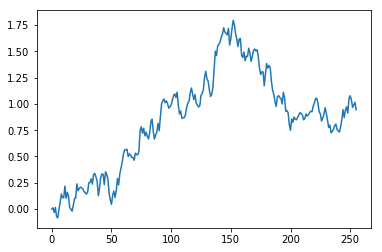

In [71]:
i=8
plt.plot(brownian_path_mod(i))
mlmc()

## Partie 3 - MLMC avec QMC

In [72]:
def mlmc_qmc():
    var=0
    L=math.trunc(np.log(1/eps)/np.log(M))
    #print(L)
    maxnl = Nl(1,L)
    P = np.empty([int(maxnl), int(L)])
    P[:] = np.nan
    #print(maxnl)
    for l in range(L):
        nl=int(Nl(l+1,L))
        disc = M**(l+1)
        # print(disc)
        simu = halton(disc, nl) 
        for i in range(nl):
            #MB = np.cumsum(norm.ppf(simu[i,:], scale=np.sqrt(1/disc)))
            #MB = brownian_path_mod(l+1)
            acc = [0] +[norm.ppf(simu[i,j], scale=np.sqrt(1/disc)) for j in range(disc-1)]
            MB = np.cumsum(np.array(acc))
            temp = 0
            for j in range(disc):
                temp=temp+S_0*np.exp((mu-sigma**2/2)*((j+1)/disc) + sigma* MB[j])
            temp=temp/disc
            val = max(0,temp-K)
            P[i,l] = np.exp(-r*T)*val
        #print(val)
        var += (np.var(P[0:nl,l])/nl)

    estimation = sum(P[:,0])/Nl(1,L)    
    #print(estimation)
    
    #print(len(P[:,0]))
    
    for l in range(1,L):
        #print('###################################')
        #print(l+1)
        nl = Nl(l+1,L)
        pp = 0
        #print(nl)
        for j in range(int(nl)):
            pp = pp+ P[j,l]-P[j,l-1]
        estimation = estimation + pp/nl
    sd = np.sqrt(var)
    intervalle = [estimation-np.sqrt((eps**2)/2),estimation+np.sqrt((eps**2)/2)]
    return estimation, intervalle, sd

In [73]:
mlmc_qmc()

(5.388069670268858, [5.384534136362925, 5.391605204174791], 0.2589363149312469)